In [1]:
from utils.Augmentation import get_augmentation
import yaml
from dotmap import DotMap
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt

In [124]:
import torch
import torch.utils.data as data
import decord
import os
import numpy as np
from numpy.random import randint
import io
import pandas as pd
import random
from PIL import Image
import math
import copy
from datasets.rand_augment import create_random_augment
from torchvision import transforms


class VideoRecord(object):
    def __init__(self, row):
        self._data = row

    @property
    def path(self):
        return self._data[0]

    @property
    def num_frames(self):
        return int(self._data[1])

    @property
    def label(self):
        return int(self._data[-1])


class Video_dataset(data.Dataset):
    def __init__(self, root_path, list_file, labels_file,
                 num_segments=1, modality='RGB', new_length=1,
                 image_tmpl='img_{:05d}.jpg', transform=None,
                 random_shift=True, test_mode=False,
                 index_bias=1, dense_sample=False, test_clips=3):

        self.root_path = root_path
        self.list_file = list_file
        self.num_segments = num_segments
        self.modality = modality
        self.seg_length = new_length
        self.image_tmpl = image_tmpl
        self.transform = transform
        self.random_shift = random_shift
        self.test_mode = test_mode
        self.loop=False
        self.index_bias = index_bias
        self.labels_file = labels_file
        self.sample_range = 128
        self.dense_sample = dense_sample  # using dense sample as I3D
        self.test_clips = test_clips
        if self.dense_sample:
            print('=> Using dense sample for the dataset...')

        if self.index_bias is None:
            if self.image_tmpl == "frame{:d}.jpg":
                self.index_bias = 0
            else:
                self.index_bias = 1
        self._parse_list()
        self.initialized = False

    @property
    def total_length(self):
        return self.num_segments * self.seg_length
    
    @property
    def classes(self):
        classes_all = pd.read_csv(self.labels_file)
        return classes_all.values.tolist()
    
    def _parse_list(self):
        # check the frame number is large >3:
        tmp = [x.strip().split(' ') for x in open(self.list_file)]
        if len(tmp[0]) == 3: # skip remove_missin for decording "raw_video label" type dataset_config
            if not self.test_mode:
                tmp = [item for item in tmp if int(item[1]) >= 8]
        self.video_list = [VideoRecord(item) for item in tmp]
        print('video number:%d' % (len(self.video_list)))

    def _sample_indices(self, video_list):
        if self.dense_sample:
            sample_pos = max(1, 1 + len(video_list) - self.sample_range)
            interval = self.sample_range // self.num_segments
            start_idx = 0 if sample_pos == 1 else np.random.randint(0, sample_pos - 1)
            base_offsets = np.arange(self.num_segments) * interval
            offsets = (base_offsets + start_idx) % len(video_list)
            return np.array(offsets) + self.index_bias
        else:
            if len(video_list) <= self.total_length:
                if self.loop:
                    return np.mod(np.arange(
                        self.total_length) + randint(len(video_list) // 2),
                        len(video_list)) + self.index_bias
                offsets = np.concatenate((
                    np.arange(len(video_list)),
                    randint(len(video_list),
                            size=self.total_length - len(video_list))))
                return np.sort(offsets) + self.index_bias
            offsets = list()
            ticks = [i * len(video_list) // self.num_segments
                    for i in range(self.num_segments + 1)]

            for i in range(self.num_segments):
                tick_len = ticks[i + 1] - ticks[i]
                tick = ticks[i]
                if tick_len >= self.seg_length:
                    tick += randint(tick_len - self.seg_length + 1)
                offsets.extend([j for j in range(tick, tick + self.seg_length)])
            return np.array(offsets) + self.index_bias

    def _get_val_indices(self, video_list):
        if self.dense_sample:
            sample_pos = max(1, 1 + len(video_list) - self.sample_range)
            t_stride = self.sample_range // self.num_segments
            start_idx = 0 if sample_pos == 1 else np.random.randint(0, sample_pos - 1)
            offsets = [(idx * t_stride + start_idx) % len(video_list) for idx in range(self.num_segments)]
            return np.array(offsets) + self.index_bias
        else:
            tick = len(video_list) / float(self.num_segments)
            offsets = [int(tick * x) % len(video_list) for x in range(self.num_segments)]
            return np.array(offsets) + self.index_bias


    def _get_test_indices(self, video_list):
        if self.dense_sample:
            # multi-clip for dense sampling
            num_clips = self.test_clips
            sample_pos = max(0, len(video_list) - self.sample_range)
            interval = self.sample_range // self.num_segments
            start_list = [clip_idx * math.floor(sample_pos / (num_clips -1)) for clip_idx in range(num_clips)]
            base_offsets = np.arange(self.num_segments) * interval
            offsets = []
            for start_idx in start_list:
                offsets.extend((base_offsets + start_idx) % len(video_list))
            return np.array(offsets) + self.index_bias
        else:
            # multi-clip for uniform sampling
            num_clips = self.test_clips
            tick = len(video_list) / float(self.num_segments)
            start_list = np.linspace(0, tick - 1, num=num_clips, dtype=int)
            offsets = []
            for start_idx in start_list.tolist():
                offsets += [
                    int(start_idx + tick * x) % len(video_list)
                    for x in range(self.num_segments)
                ]
            return np.array(offsets) + self.index_bias



    def _decord_decode(self, video_path):
        try:
            container = decord.VideoReader(video_path)
        except Exception as e:
            print("Failed to decode {} with exception: {}".format(
                video_path, e))
            return None
        
        return container

    def __getitem__(self, index):
        # decode frames to video_list
        if self.modality == 'video':
            _num_retries = 10
            for i_try in range(_num_retries):
                record = copy.deepcopy(self.video_list[index])
                directory = os.path.join(self.root_path, record.path)
                video_list = self._decord_decode(directory)
                # video_list = self._decord_pyav(directory)
                if video_list is None:
                    print("Failed to decode video idx {} from {}; trial {}".format(
                        index, directory, i_try)
                    )
                    index = random.randint(0, len(self.video_list))
                    continue
                break
        else:
            record = self.video_list[index]
            video_list = os.listdir(os.path.join(self.root_path, record.path))

        if not self.test_mode: # train/val
            segment_indices = self._sample_indices(video_list) if self.random_shift else self._get_val_indices(video_list) 
        else: # test
            segment_indices = self._get_test_indices(video_list)

        return self.get(record, video_list, segment_indices)


    def _load_image(self, directory, idx):
        if self.modality == 'RGB':
            try:
                return [Image.open(os.path.join(self.root_path, directory, self.image_tmpl.format(idx))).convert('RGB')]
            except Exception:
                print('error loading image:', os.path.join(self.root_path, directory, self.image_tmpl.format(idx)))
                return [Image.open(os.path.join(self.root_path, directory, self.image_tmpl.format(1))).convert('RGB')]


    def get(self, record, video_list, indices):
        images = list()
        for seg_ind in indices:
            p = int(seg_ind)
            if self.modality == 'video':
                seg_imgs = [Image.fromarray(video_list[p-1].asnumpy()).convert('RGB')]
            else:
                seg_imgs = self._load_image(record.path,p)
            images.extend(seg_imgs)
            if p < len(video_list):
                p += 1
                
        aug_transform = create_random_augment(
                input_size=(224,224),
                auto_augment="rand-m9-n2-mstd0.5-inc1",
                interpolation="bicubic",
            )
        images = aug_transform(images)

        process_data, record_label = self.transform((images,record.label))

        return process_data, record_label

    def __len__(self):
        return len(self.video_list)

In [125]:
with open("configs/k400/k400_train_rgb_vitb-16-f8.yaml", 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config = DotMap(config)

In [126]:
transform_train = get_augmentation(True, config)
transform_val = get_augmentation(False, config)

In [127]:
val_data = Video_dataset(
        "/svl/data/kinetics-400/video_frames/val", "/vision/u/eatang/leaky_video/datasets/kinetics/kinetics_rgb_val_labels.txt",
        "/vision/u/eatang/leaky_video/datasets/kinetics/kinetics_400_labels.csv", num_segments=8,
        modality="RGB",
        image_tmpl="img_{:05d}.jpg", random_shift=False,
        transform=transform_val, dense_sample=config.data.dense)

video number:19286


In [148]:
video, label = val_data.__getitem__(1)
video = video.view(8, 3, 224,224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


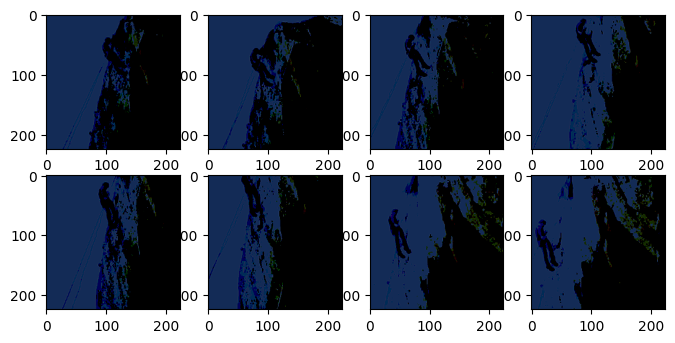

In [149]:
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, 9):
    img = video[i-1, :,:,:]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.permute((1,2,0)))
plt.show()

In [33]:
label

0

In [24]:
transform_train

Compose(
    Compose(
    Compose(
)
)
    Compose(
)
)